<a href="https://colab.research.google.com/github/WaseemAkram10000/Internship-Projects/blob/main/Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import randint

In [2]:
# Load the dataset
file_path = 'car prices.csv'
df = pd.read_csv(file_path)

In [3]:
# Data Exploration
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB
None
              year  selling_price      km_driven
count  4340.000000   4.340000e+03    4340.000000
mean   2013.090783   5.041273e+05   66215.777419
std       4.215344   5.785487e+05   46644.102194
min    1992.000000   2.000000e+04       1.000000
25%    2011.000000   2.087498e+05   35000.000000
50%    2014.000000   3.500000e+05   60000.000000
75%    2016.000000   6.000000e+05   90000.000000
max    2020.000

<Figure size 1000x600 with 0 Axes>

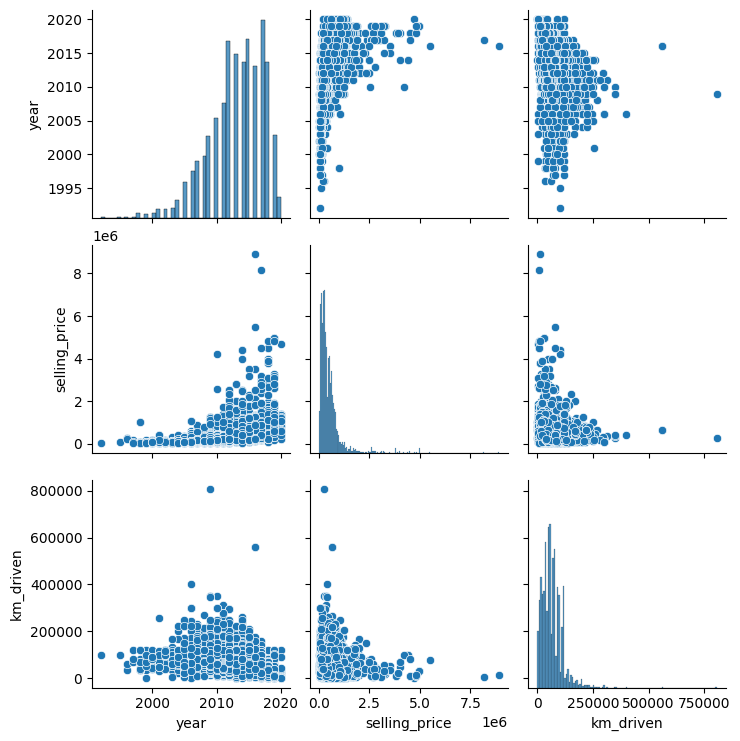

In [4]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.pairplot(df)
plt.show()

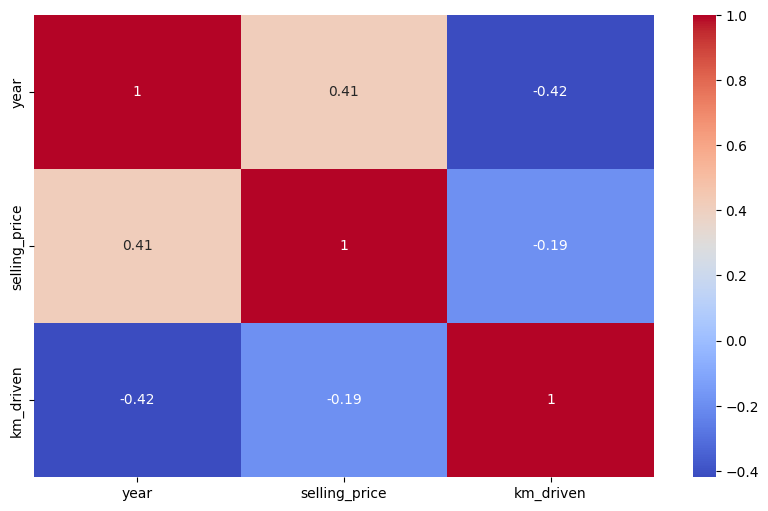

In [5]:
# Correlation heatmap for numeric columns
plt.figure(figsize=(10, 6))
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.show()

In [6]:
# Feature Engineering
df['age'] = 2024 - df['year']  # Assuming the current year is 2024
df = df.drop(columns='year')

X = df.drop(columns='selling_price')
y = df['selling_price']

In [7]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [8]:
# Preprocessing pipelines for numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [9]:
# Model pipelines
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'model__n_estimators': randint(100, 300),
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 4)
}

random_search = RandomizedSearchCV(model_pipeline, param_distributions=param_dist, n_iter=50, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['km_driven', 'age'], dtype='object')),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               Index(['name', 'fuel', 'seller_type', 'transmission', 'owner'], dtype='object'))])),
                                             ('model',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=50...
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b39a9c56020>,
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b39ae03e3b0>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b39a9c56110>},
                   random_state=42, scoring='neg_mean_absolute_error')

In [12]:
# Evaluate the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [13]:
# Cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -np.mean(cv_scores)

results = {
    'Best Model': {'MAE': mae, 'RMSE': rmse, 'CV MAE': cv_mae}
}

In [14]:
# Display results
results_df = pd.DataFrame(results).T
print(results_df)

                   CV MAE            MAE           RMSE
Best Model  119728.354657  118913.741426  360738.940288


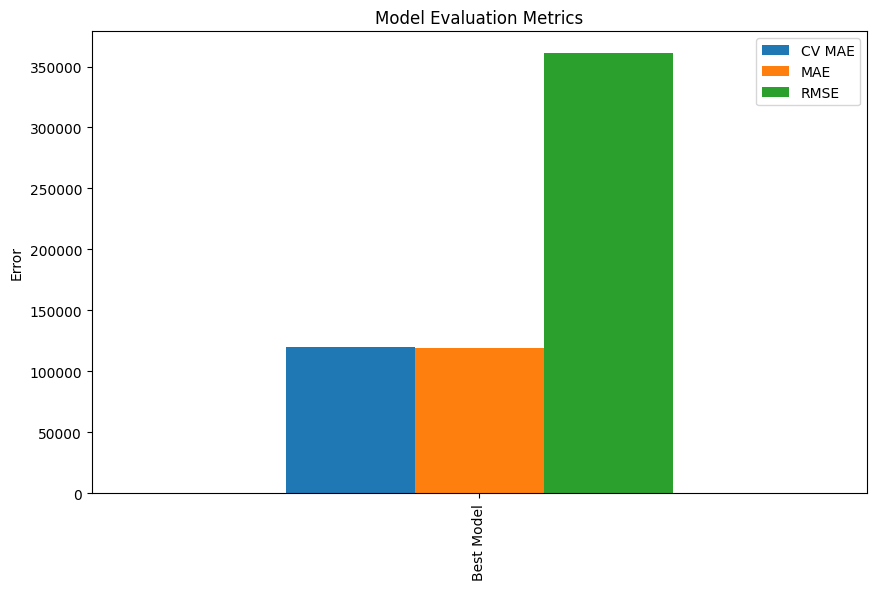

In [15]:
# Plot results
results_df.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Error')
plt.title('Model Evaluation Metrics')
plt.show()